# Loading data and basic operations for pyspark

### Data extracted from: https://catalog.data.gov/dataset/consumer-complaint-database
### Size: 2.8 Gb

## Learnings:
### Use PySpark for heavy lifting – data processing, aggregation, and transformation – and then convert a much smaller, manageable subset of this processed data into a Pandas DataFrame for visualization

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, year, col, month
from pyspark.sql.functions import month
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder \
        .appName("ComplaintAnalyser") \
        .getOrCreate()


df = spark.read.csv("complaints.csv", header=True, inferSchema=True)



In [2]:
df.columns

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID']

In [3]:
df.show(n= 5)

+-------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+----+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|Date received|             Product|     Sub-product|               Issue|           Sub-issue|Consumer complaint narrative|Company public response|             Company|State|ZIP code|Tags|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+-------------+--------------------+----------------+--------------------+--------------------+----------------------------+-----------------------+--------------------+-----+--------+----+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|   2023-1

In [4]:
(df.withColumn("date", to_date('Date received'))
  .withColumn("year", year('date'))
  .groupBy("year")
  .count()
  .orderBy(col("year").desc())
  .show(df.count()))


+------+-------+
|  year|  count|
+------+-------+
|111296|      1|
|111203|      1|
|107306|      3|
|107204|      2|
|106386|      1|
|104208|      2|
| 19176|      1|
|  3913|      1|
|  2607|      1|
|  2402|      2|
|  2023|1254609|
|  2022| 800380|
|  2021| 496009|
|  2020| 444299|
|  2019| 277299|
|  2018| 257223|
|  2017| 242857|
|  2016| 191434|
|  2015| 168451|
|  2014| 153011|
|  2013| 108215|
|  2012|  72372|
|  2011|   2536|
|  2010|      3|
|  1999|      3|
|  1986|      1|
|  1970|      3|
|  1635|      3|
|  1611|      1|
|  1397|      1|
|  1234|      1|
|  1028|      1|
|  1006|      1|
|   815|      1|
|  NULL|2252220|
+------+-------+



In [5]:
df_n = df.withColumn("date", to_date('Date received')).withColumn("year", year('date'))

# Inspect rows with valid years
filtered_df = df_n.filter(col('year').between(2011, 2023))



In [33]:
result_data=invalid_years_df.select('Product','Issue','Sub-issue').limit(50).collect()

import csv

with open('temp_error_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([column for column in invalid_years_df.columns])
    for row in result_data:
        writer.writerow(row)

In [7]:
filtered_df.printSchema()

root
 |-- Date received: string (nullable = true)
 |-- Product: string (nullable = true)
 |-- Sub-product: string (nullable = true)
 |-- Issue: string (nullable = true)
 |-- Sub-issue: string (nullable = true)
 |-- Consumer complaint narrative: string (nullable = true)
 |-- Company public response: string (nullable = true)
 |-- Company: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP code: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Consumer consent provided?: string (nullable = true)
 |-- Submitted via: string (nullable = true)
 |-- Date sent to company: string (nullable = true)
 |-- Company response to consumer: string (nullable = true)
 |-- Timely response?: string (nullable = true)
 |-- Consumer disputed?: string (nullable = true)
 |-- Complaint ID: string (nullable = true)
 |-- date: date (nullable = true)
 |-- year: integer (nullable = true)



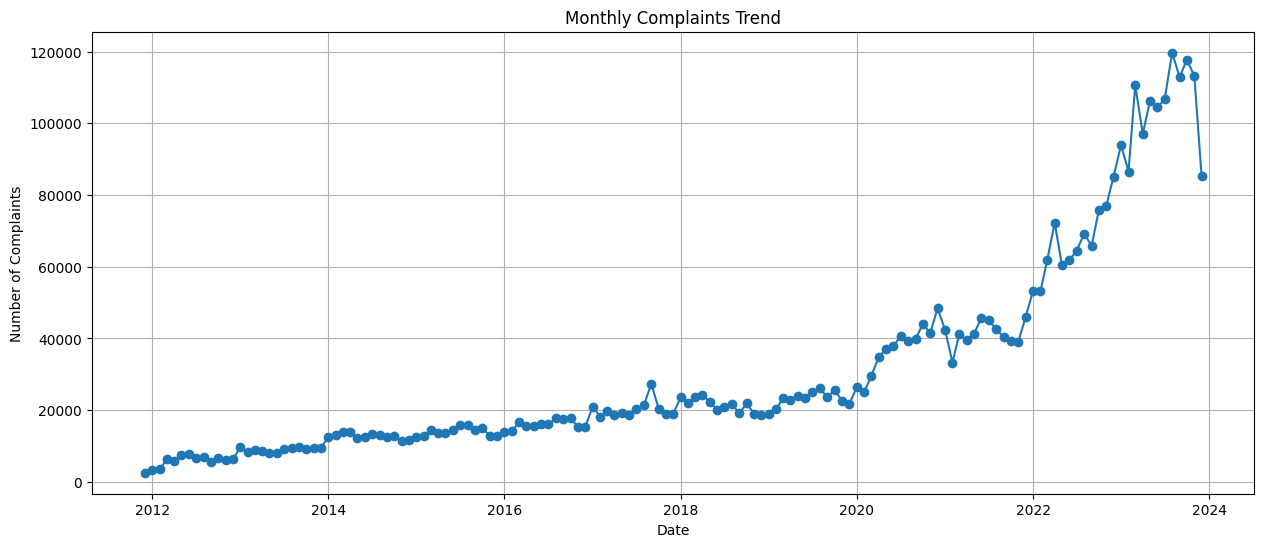

In [21]:

filtered_df = filtered_df.withColumn("Month", month("Date received"))
monthly_trend = filtered_df.groupBy("year", "Month").count().orderBy("year", "Month")

monthly_trend_pd = monthly_trend.toPandas()
monthly_trend_pd['Date'] = pd.to_datetime(monthly_trend_pd[['year', 'Month']].assign(DAY=1))
plt.figure(figsize=(15, 6))
plt.plot(monthly_trend_pd['Date'], monthly_trend_pd['count'], marker='o')
plt.title('Monthly Complaints Trend')
plt.xlabel('Date')
plt.ylabel('Number of Complaints')
plt.grid(True)
plt.show()



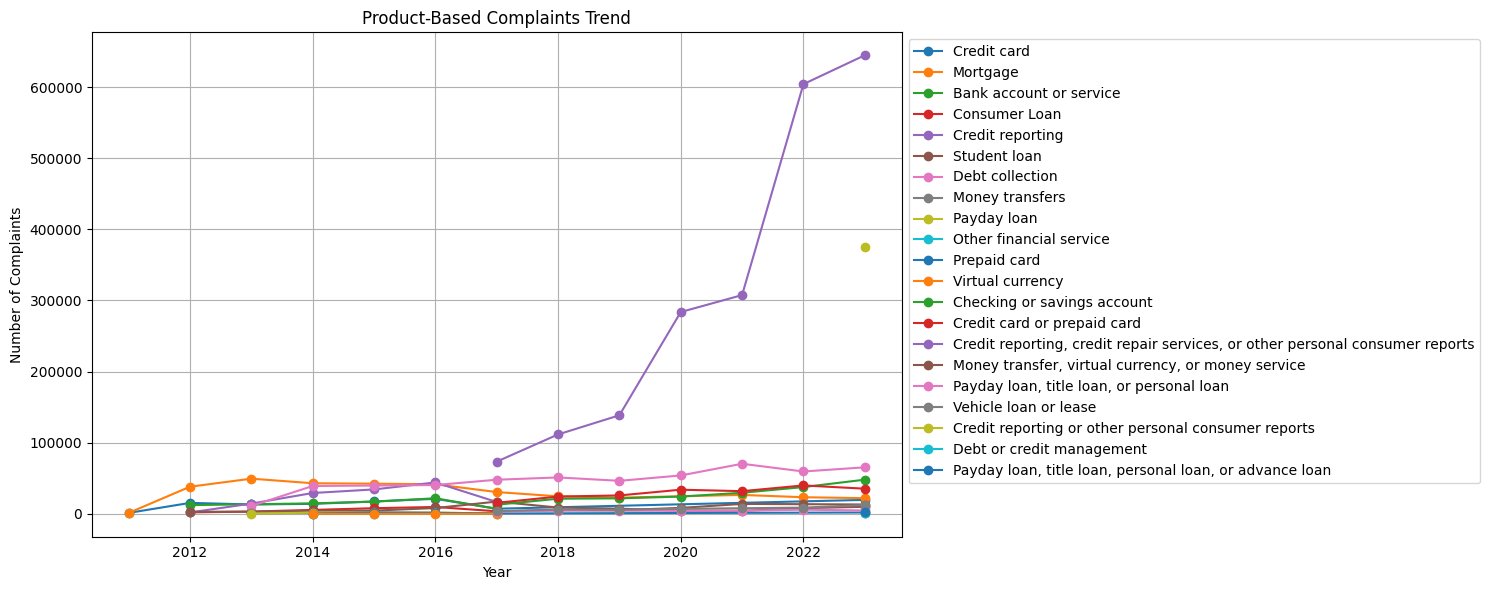

In [29]:
product_trend = filtered_df.groupBy("year", "Product").count().orderBy("year", "Product")
product_trend_pd = product_trend.toPandas()

plt.figure(figsize=(15, 6))
for product in product_trend_pd['Product'].unique():
    subset = product_trend_pd[product_trend_pd['Product'] == product]
    plt.plot(subset['year'], subset['count'], marker='o', label=product)

plt.title('Product-Based Complaints Trend')
plt.xlabel('Year')
plt.ylabel('Number of Complaints')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  
plt.grid(True)
plt.tight_layout()  
plt.show()


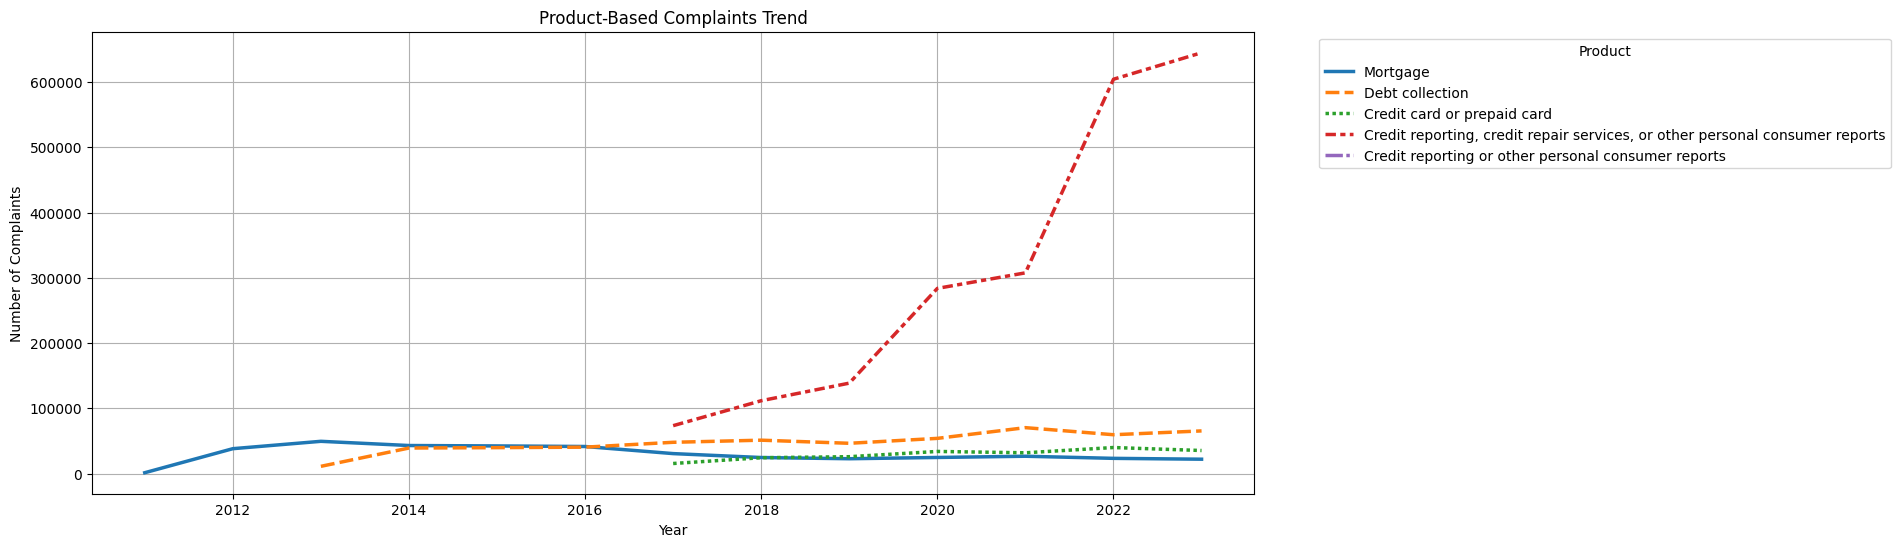

In [28]:

# Limit to top N products
top_products = product_trend_pd.groupby('Product')['count'].sum().nlargest(5).index
filtered_data = product_trend_pd[product_trend_pd['Product'].isin(top_products)]

plt.figure(figsize=(15, 6))
sns.lineplot(data=filtered_data, x='year', y='count', hue='Product', 
             linewidth=2.5, style='Product', palette='tab10')

plt.title('Product-Based Complaints Trend')
plt.xlabel('Year')
plt.ylabel('Number of Complaints')
plt.legend(title='Product', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
